# Leios simulation analysis at tag `leios-2025w26`

## Load packages

In [1]:
suppressMessages({
    require(data.table, quietly=TRUE)
    require(ggplot2, quietly=TRUE)
    require(magrittr, quietly=TRUE)
})

## Experiment: simple variant with conflicts

In [2]:
label <- "Rust simulator, mini-mainnet, 100 tx/s, 0.2 IB/s, 10 slot/stage, 2 MB/IB maximum, 2.5 EB/stage, simple variant"

### Analysis of lifecycles and efficiencies

#### Read the lifecycle results

In [3]:
lifecycle <- fread("results/cxs/lifecycle.csv.gz", stringsAsFactors=TRUE)
lifecycle[, `Kind`:=factor(`Kind`, levels=c("RB", "EB", "IB", "TX"))]
lifecycle %>% summary

 Simulator     Conflict fraction Kind                   Item       
 Rust:181965   Min.   :0.00      RB:   168   0            :     3  
               1st Qu.:0.00      EB:   657   1            :     3  
               Median :0.25      IB:   543   10           :     3  
               Mean   :0.25      TX:180597   10-node-220-0:     3  
               3rd Qu.:0.50                  100          :     3  
               Max.   :0.50                  100-node-174 :     3  
                                             (Other)      :181947  
    Size [B]         References      Created [s]       To IB [s]     
 Min.   :      8   Min.   : 0.000   Min.   :  5.13   Min.   : 62.13  
 1st Qu.:    439   1st Qu.: 1.000   1st Qu.:210.07   1st Qu.:220.13  
 Median :    938   Median : 1.000   Median :359.80   Median :371.13  
 Mean   :   3943   Mean   : 1.406   Mean   :360.56   Mean   :369.11  
 3rd Qu.:   2012   3rd Qu.: 2.000   3rd Qu.:509.77   3rd Qu.:512.13  
 Max.   :2097456   Max.   :83.000   

In [4]:
cxLevels <- paste0(lifecycle[, sort(unique(100 * `Conflict fraction`))], "% conflicts")
cxFactor <- function(cx, decreasing=FALSE) factor(paste0(100 * cx, "% conflicts"), levels=mapply(ifelse, decreasing, rev(cxLevels), cxLevels))

In [5]:
lifecycle[, `Conflict fraction`:=cxFactor(`Conflict fraction`, FALSE)]

#### Range of transaction injection

In [6]:
txFirst <- 60
txLast <- 660
txWindow <- txLast - txFirst
simFinish <- 900

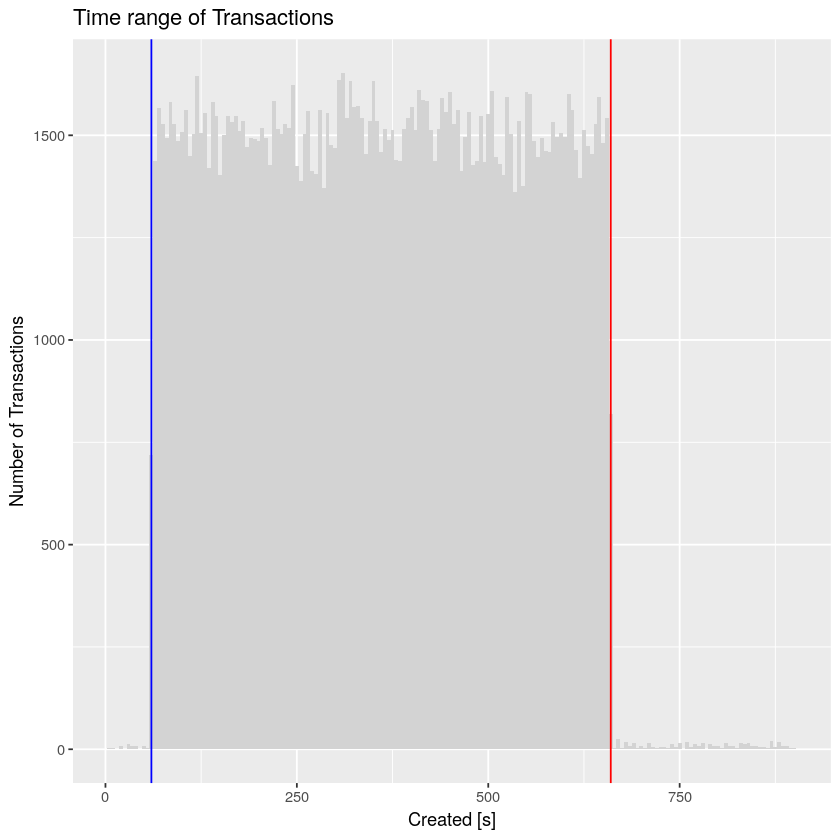

In [7]:
ggplot(lifecycle, aes(x=`Created [s]`)) +
    geom_histogram(binwidth=5, fill="lightgray") +
    geom_vline(xintercept=txFirst, color="blue") +
    geom_vline(xintercept=txLast, color="red") +
    ylab("Number of Transactions") +
    ggtitle("Time range of Transactions")

#### Actual TPS

In [8]:
lifecycle[
    `Kind` == "TX" & `Created [s]` >= txFirst & `Created [s]` <= txLast, 
    .(
        `Demand [tx/s]`=.N/txWindow,
        `Demand [MB/s]`=sum(`Size [B]`)/1e6/txWindow,
        `Demand [IB/s]`=sum(`Size [B]`)/txWindow/1024/2048/0.2
    ),
    .(`Conflict fraction`)
]

Conflict fraction,Demand [tx/s],Demand [MB/s],Demand [IB/s]
<fct>,<dbl>,<dbl>,<dbl>
0% conflicts,100.3317,0.1715755,0.4090678
25% conflicts,100.3317,0.1715755,0.4090678
50% conflicts,100.3317,0.1715755,0.4090678


#### Size of persisted data

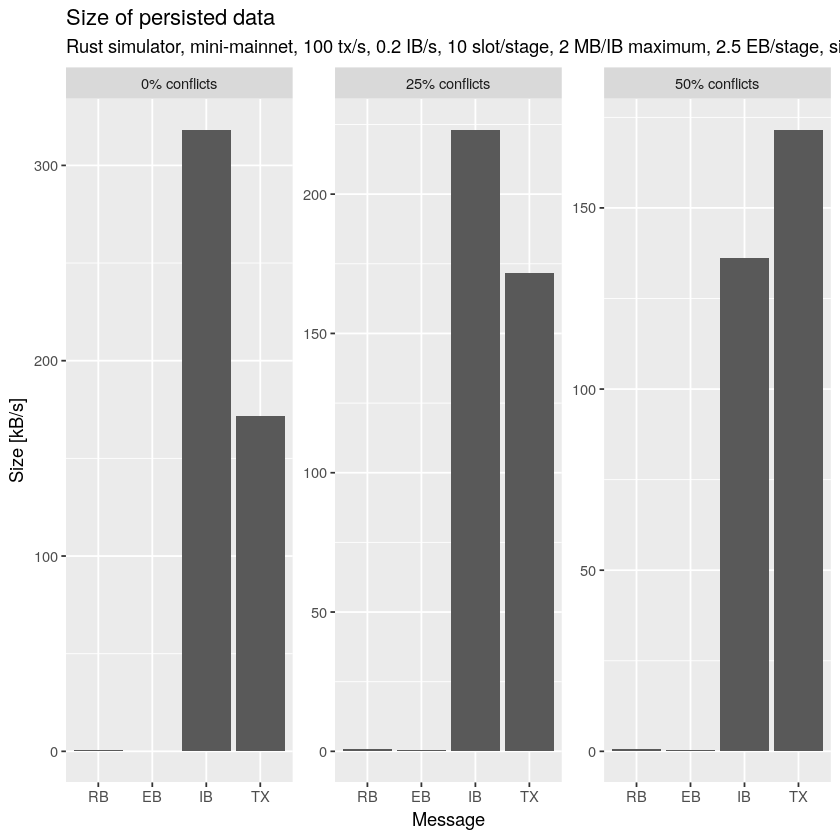

In [9]:
ggplot(
    lifecycle[, .(`Size [kB/s]`=sum(`Size [B]`)/1e3/600), .(`Message`=`Kind`, `Conflict fraction`)],
    aes(x=`Message`, y=`Size [kB/s]`)
) + geom_bar(stat="identity") +
    facet_wrap(`Conflict fraction` ~ ., scales="free") +
    ggtitle("Size of persisted data", subtitle=label)

In [10]:
ggsave("plots/cxs/sizes.png", units="in", dpi=150, width=8, height=6)

In [11]:
ggsave("plots/cxs/sizes.svg", units="in", dpi=150, width=8, height=6)

#### Spatial efficiency

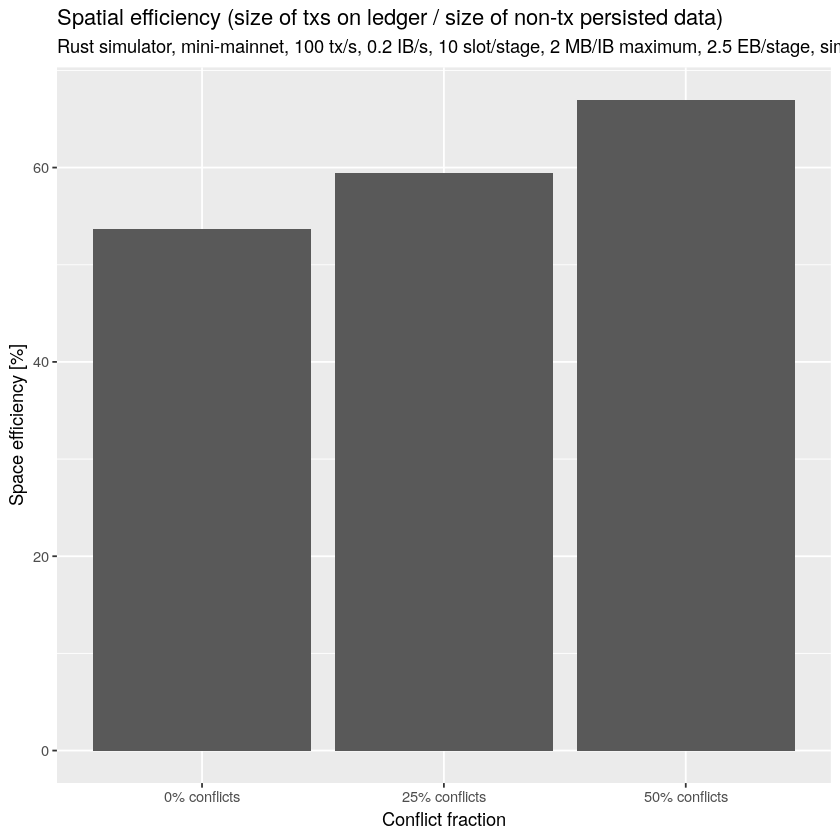

In [12]:
ggplot(
    lifecycle[
        `Kind` == "TX", 
        .(`Tx size [B]`=sum(ifelse(is.na(`To RB [s]`) & is.na(`In RB [s]`), 0, 1.0 * `Size [B]`))),
        .(`Conflict fraction`)
    ][
        lifecycle[
            `Kind` != "TX", 
            .(`Non-tx size [B]`=sum(as.numeric(`Size [B]`))), 
            .(`Conflict fraction`)
        ],
        on=c("Conflict fraction")
    ][, .(`Conflict fraction`, `Space efficiency [%]`=100*`Tx size [B]`/`Non-tx size [B]`)],
    aes(x=`Conflict fraction`, y=`Space efficiency [%]`)
) +
    geom_bar(stat="identity") +
    ggtitle("Spatial efficiency (size of txs on ledger / size of non-tx persisted data)", label)

In [13]:
ggsave("plots/cxs/spatial-efficiency.png", units="in", dpi=150, width=8, height=6)

In [14]:
ggsave("plots/cxs/spatial-efficiency.svg", units="in", dpi=150, width=8, height=6)

#### Time to reach the ledger

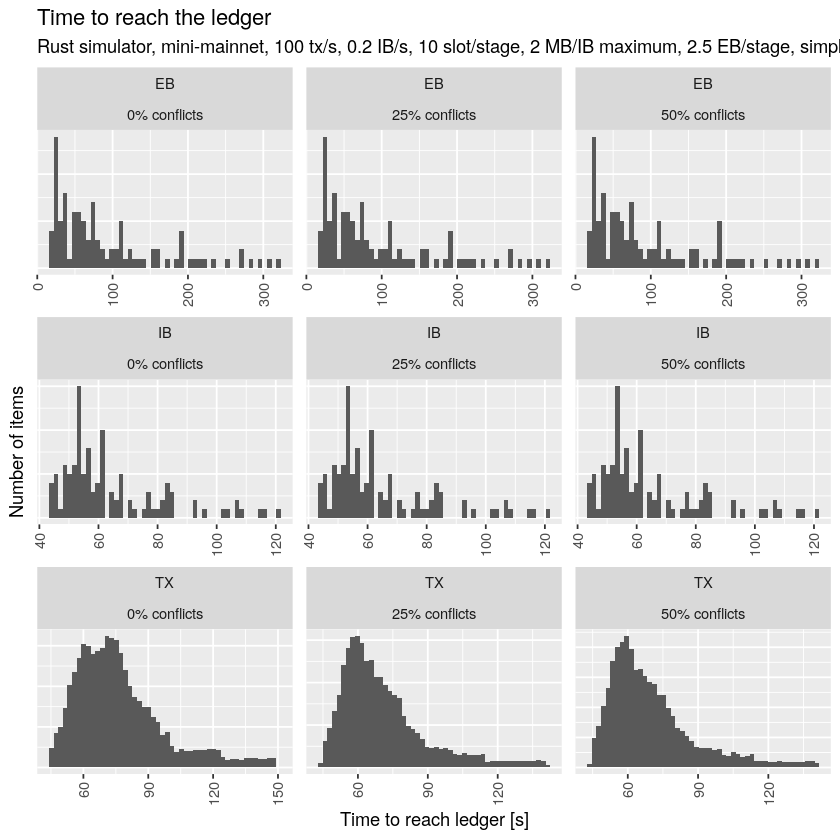

In [15]:
ggplot(
    lifecycle[
        `Kind` %in% c("TX", "IB", "EB") & 
        !is.na(`To RB [s]`) & 
        `Created [s]` >= txFirst & `Created [s]` <= txLast, 
        .(`Time to reach ledger [s]`=`To RB [s]`-`Created [s]`), 
        .(`Kind`, `Conflict fraction`)
    ],
    aes(x=`Time to reach ledger [s]`)
) + geom_histogram(bins=50) +
    facet_wrap(`Kind` ~ `Conflict fraction`, scales="free", nrow=3) +
    ylab("Number of items") +
    ggtitle("Time to reach the ledger", label) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1), axis.text.y = element_blank(), axis.ticks.y = element_blank())

In [16]:
ggsave("plots/cxs/reach-rb.png", units="in", dpi=150, width=8, height=6)

In [17]:
ggsave("plots/cxs/reach-rb.svg", units="in", dpi=150, width=8, height=6)

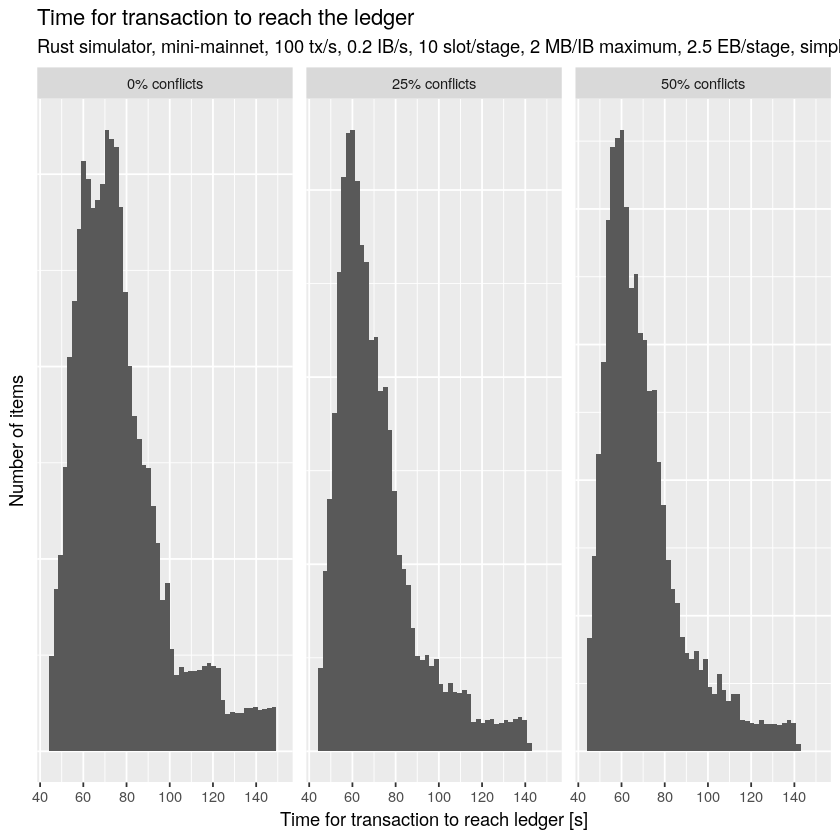

In [18]:
ggplot(
    lifecycle[
        `Kind` == "TX" & 
        !is.na(`To RB [s]`) &
        `Created [s]` >= txFirst & `Created [s]` <= txLast, 
        .(`Time to reach ledger [s]`=`To RB [s]`-`Created [s]`), 
        .(`Kind`, `Conflict fraction`)
    ],
    aes(x=`Time to reach ledger [s]`)
) + geom_histogram(bins=50) +
    facet_wrap(. ~ `Conflict fraction`, scales="free_y", ncol=3) +
    xlab("Time for transaction to reach ledger [s]") +
    ylab("Number of items") +
    ggtitle("Time for transaction to reach the ledger", label) +
    theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())

In [19]:
ggsave("plots/cxs/reach-rb-tx.png", units="in", dpi=150, width=8, height=6)

In [20]:
ggsave("plots/cxs/reach-rb-tx.svg", units="in", dpi=150, width=8, height=6)

#### Time to reach an EB

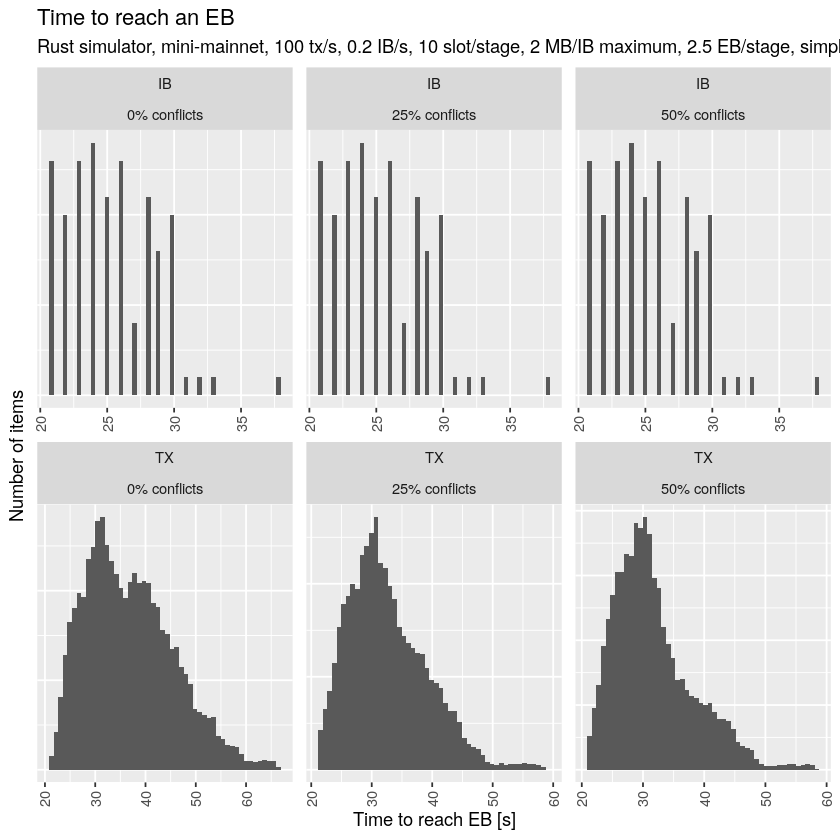

In [21]:
ggplot(
    lifecycle[
        `Kind` %in% c("TX", "IB") & 
        !is.na(`To EB [s]`) & 
        `Created [s]` >= txFirst & `Created [s]` <= txLast, 
        .(`Time to reach EB [s]`=`To EB [s]`-`Created [s]`), 
        .(`Kind`, `Conflict fraction`)
    ],
    aes(x=`Time to reach EB [s]`)
) + geom_histogram(bins=50) +
    facet_wrap(`Kind` ~ `Conflict fraction`, scales="free", nrow=2) +
    ylab("Number of items") +
    ggtitle("Time to reach an EB", label) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1), axis.text.y = element_blank(), axis.ticks.y = element_blank())

In [22]:
ggsave("plots/cxs/reach-eb.png", units="in", dpi=150, width=8, height=6)

In [23]:
ggsave("plots/cxs/reach-eb.svg", units="in", dpi=150, width=8, height=6)

#### Time to reach an IB

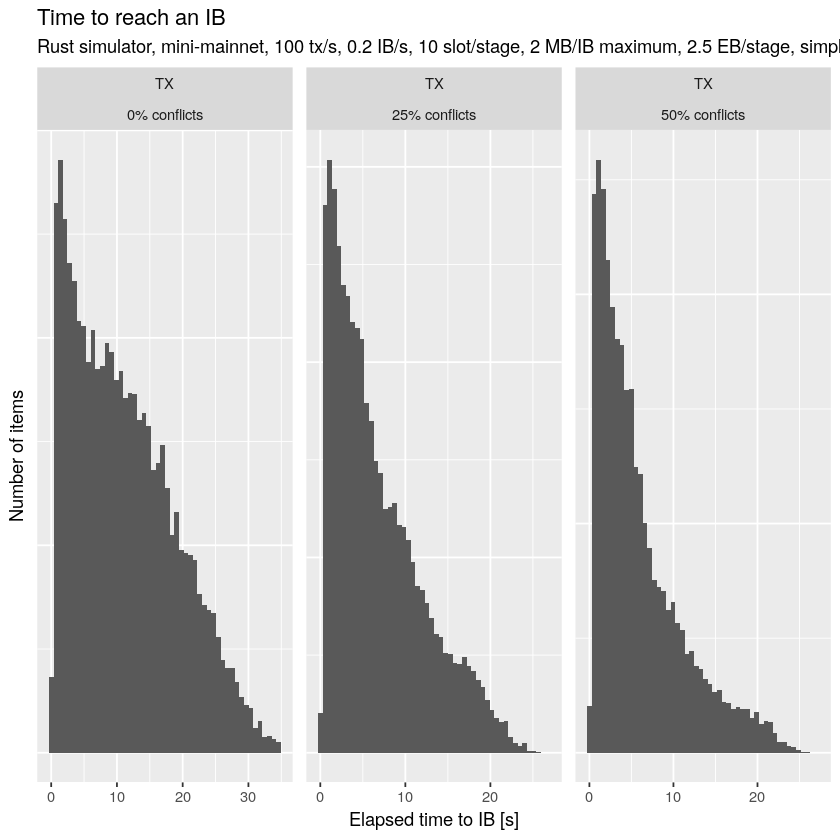

In [24]:
ggplot(
    lifecycle[
        `Kind` %in% c("TX") & 
        !is.na(`To IB [s]`) & 
        `Created [s]` >= txFirst & `Created [s]` <= txLast, 
        .(`Elapsed time to IB [s]`=`To IB [s]`-`Created [s]`), 
        .(`Kind`, `Conflict fraction`)],
    aes(x=`Elapsed time to IB [s]`)
) + geom_histogram(bins=50) +
    facet_wrap(`Kind` ~ `Conflict fraction`, scales="free", ncol=3) +
    ylab("Number of items") +
    ggtitle("Time to reach an IB", label) +
    theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())

In [25]:
ggsave("plots/cxs/reach-ib.png", units="in", dpi=150, width=8, height=6)

In [26]:
ggsave("plots/cxs/reach-ib.svg", units="in", dpi=150, width=8, height=6)

#### Number of references

A *reference* is one of the following:

- A transaction is included in an IB.
- An IB is referenced by an EB.
- An EB is referenced by another EB.

In an efficient Leios, the number of references for each data item would be one.

- *Zero references* indicates that the item was not used.
- *Two or more references* indicates that duplication has occurred.

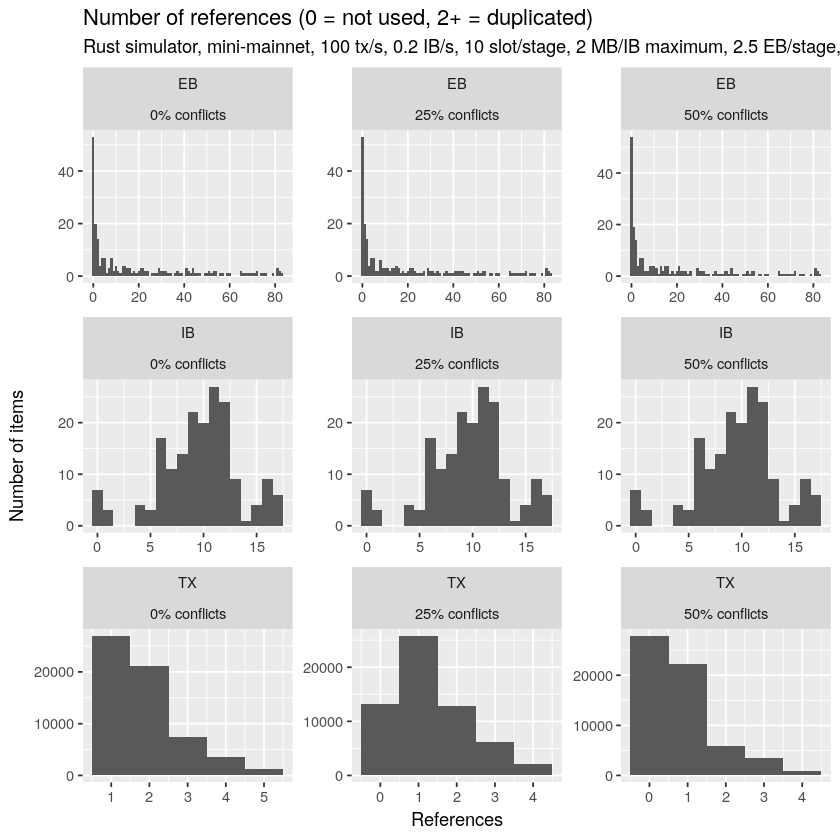

In [27]:
ggplot(
    lifecycle[
        `Kind` %in% c("TX", "IB", "EB")
    ], 
    aes(x=`References`)
) +
    geom_histogram(binwidth=1) +
    facet_wrap(`Kind` ~ `Conflict fraction`, scales="free", nrow=3) +
    ylab("Number of items") +
    ggtitle("Number of references (0 = not used, 2+ = duplicated)", label)

In [28]:
ggsave("plots/cxs/references.png", units="in", dpi=150, width=8, height=6)

In [29]:
ggsave("plots/cxs/references.svg", units="in", dpi=150, width=8, height=6)

#### Temporal efficiency

In [30]:
toElapsed <- function(created, toRb, inRb) {
    if (!is.na(toRb))
        toRb - created
    else if (!is.na(inRb))
        inRb - created
    else
        NA
}

In [31]:
outcomes <- lifecycle[
    `Kind` == "TX",
    .(
        `Submitted [minute]`=factor(ceiling(`Created [s]`/60)), 
        `Time to reach ledger [s]`=mapply(toElapsed, `Created [s]`, `To RB [s]`, `In RB [s]`)
    ), .(
        `Conflict fraction`
    )
][order(`Conflict fraction`, `Submitted [minute]`, `Time to reach ledger [s]`)]

In [32]:
totals <- outcomes[, .(`Total`=.N, `Lost`=sum(is.na(`Time to reach ledger [s]`))), .(`Conflict fraction`, `Submitted [minute]`)]

#### Transactions reaching the ledger

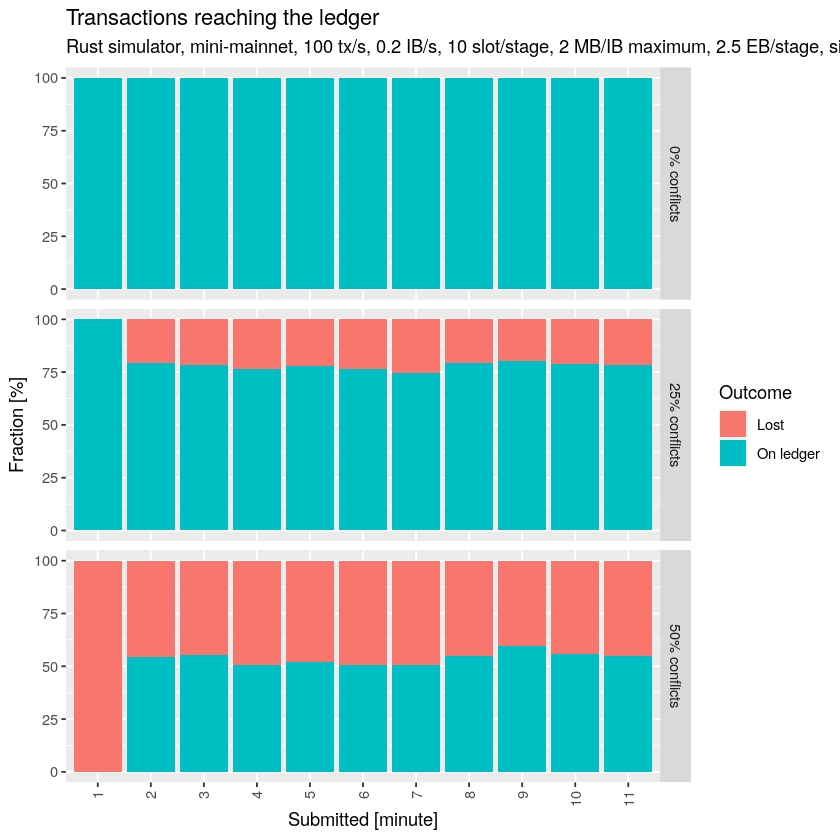

In [33]:
ggplot(
    melt(
        totals[, .(`On ledger`=1-`Lost`/`Total`, `Lost`=`Lost`/`Total`), .(`Conflict fraction`, `Submitted [minute]`)],
        id.vars=c("Conflict fraction", "Submitted [minute]"),
        variable.name="Outcome",
        value.name="Fraction"
    )[, .(
        `Conflict fraction`, 
        `Submitted [minute]`, 
        `Outcome`=factor(`Outcome`,levels=c("Lost","On ledger")), 
        `Fraction [%]`=100*`Fraction`
    )],
    aes(x=`Submitted [minute]`, y=`Fraction [%]`, fill=`Outcome`)
) +
    geom_bar(stat="identity") +
    facet_grid(`Conflict fraction` ~ .) +
    ggtitle("Transactions reaching the ledger", label) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

In [34]:
ggsave("plots/cxs/temporal-efficiency-bar.png", units="in", dpi=150, width=8, height=6)

In [35]:
ggsave("plots/cxs/temporal-efficiency-bar.svg", units="in", dpi=150, width=8, height=6)

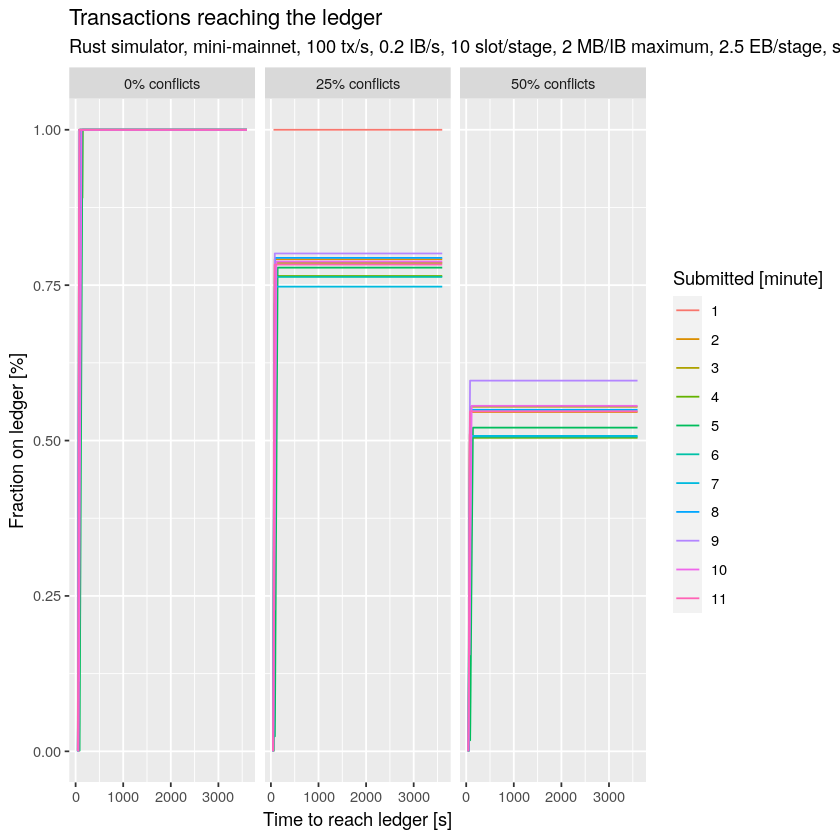

In [36]:
ggplot(
    rbind(
        totals[
            outcomes[!is.na(`Time to reach ledger [s]`), .(`Cumulative total`=1:length(`Time to reach ledger [s]`), `Time to reach ledger [s]`), .(`Conflict fraction`, `Submitted [minute]`)],
            on=c("Conflict fraction", "Submitted [minute]")
        ][,
            .(`Time to reach ledger [s]`, `Fraction on ledger [%]`=`Cumulative total`/`Total`),
            .(`Conflict fraction`, `Submitted [minute]`)
        ],
        totals[, .(`Fraction on ledger [%]`=1-`Lost`/`Total`, `Time to reach ledger [s]`=3600), .(`Conflict fraction`, `Submitted [minute]`)]
    )[`Submitted [minute]` != 0],
    aes(x=`Time to reach ledger [s]`, y=`Fraction on ledger [%]`, color=`Submitted [minute]`)
) +
    geom_line() +
    facet_wrap(`Conflict fraction` ~ .) +
    ggtitle("Transactions reaching the ledger", label)

In [37]:
ggsave("plots/cxs/temporal-efficiency-timeseries.png", units="in", dpi=150, width=8, height=6)

In [38]:
ggsave("plots/cxs/temporal-efficiency-timeseries.svg", units="in", dpi=150, width=8, height=6)

#### Release memory

In [39]:
rm(lifecycle, outcomes, totals)

### Resource usage

In [40]:
resources <- fread("results/cxs/resources.csv.gz", stringsAsFactors=TRUE)
resources %>% summary

 Simulator   Conflict fraction       Node        Egress [B]       
 Rust:2250   Min.   :0.00      node-0  :   3   Min.   :3.255e+04  
             1st Qu.:0.00      node-1  :   3   1st Qu.:1.038e+07  
             Median :0.25      node-10 :   3   Median :1.708e+08  
             Mean   :0.25      node-100:   3   Mean   :2.297e+08  
             3rd Qu.:0.50      node-101:   3   3rd Qu.:3.306e+08  
             Max.   :0.50      node-102:   3   Max.   :1.775e+09  
                               (Other) :2232                      
    Disk [B]       Total CPU [s]   Maximum CPU [s/s]
 Min.   :      0   Min.   :139.4   Min.   :1.213    
 1st Qu.:      0   1st Qu.:168.4   1st Qu.:2.322    
 Median :      0   Median :202.3   Median :2.482    
 Mean   : 181609   Mean   :199.0   Mean   :2.444    
 3rd Qu.:      0   3rd Qu.:238.2   3rd Qu.:2.594    
 Max.   :5620654   Max.   :238.6   Max.   :3.900    
                                                    

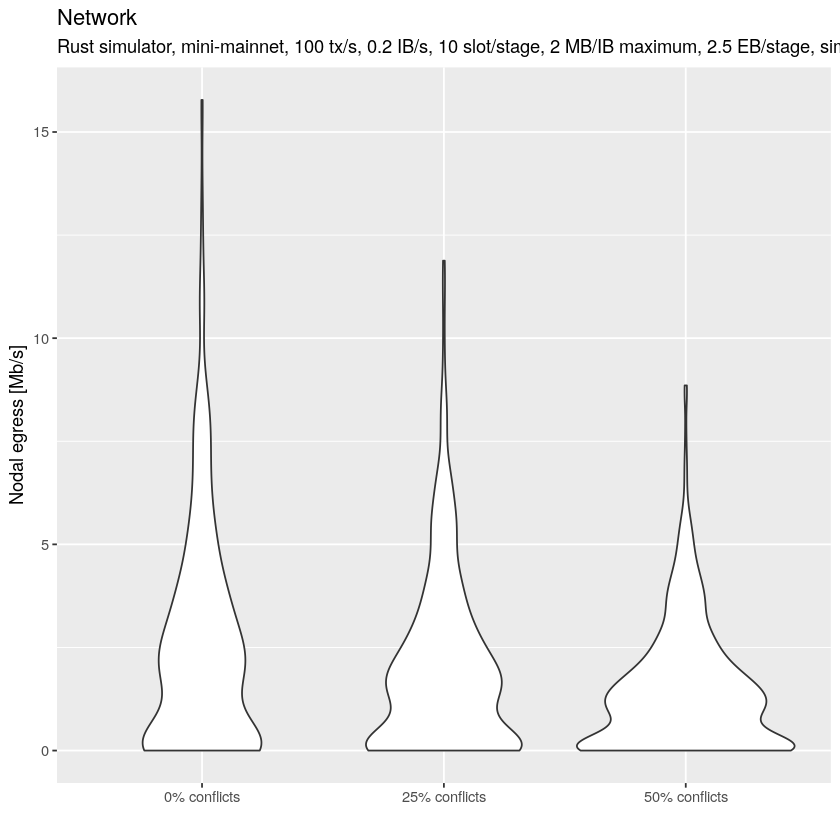

In [41]:
ggplot(
    resources[, .(`Conflict fraction`=cxFactor(`Conflict fraction`), `Node`, `Nodal egress [Mb/s]`=8*`Egress [B]`/simFinish/1e6)], 
    aes(x=`Conflict fraction`, y=`Nodal egress [Mb/s]`)
) +
    geom_violin() +
    xlab("") +
    ggtitle("Network", label)

In [42]:
ggsave("plots/cxs/network.png", units="in", dpi=150, width=9.5, height=5.5)

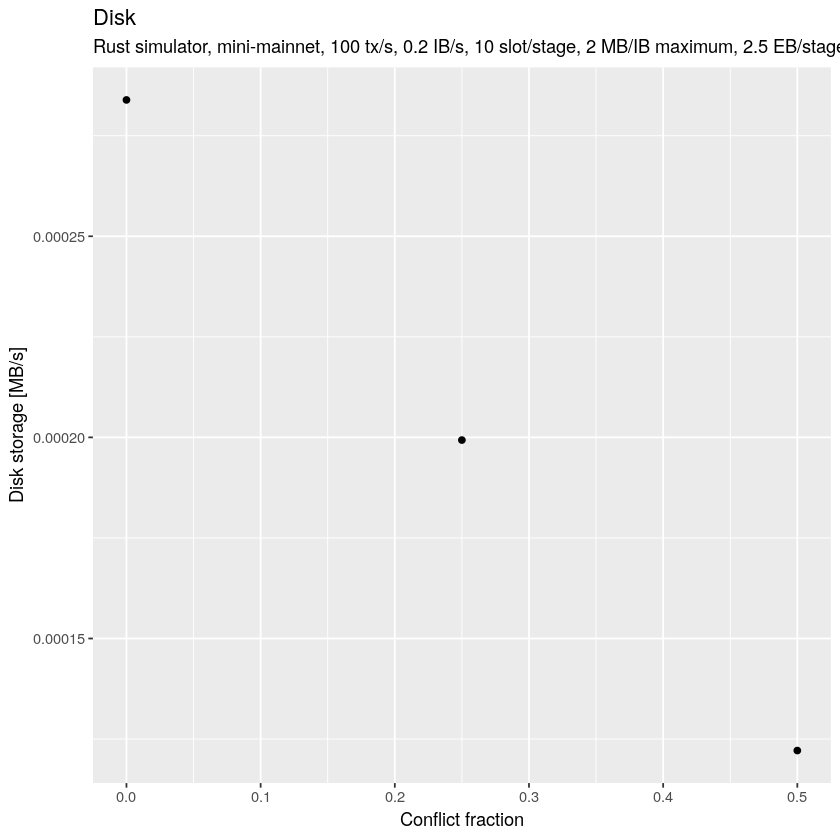

In [43]:
ggplot(
    resources[, .(`Disk storage [MB/s]`=mean(`Disk [B]`)/simFinish/1e6), .(`Conflict fraction`)],
    aes(x=`Conflict fraction`, y=`Disk storage [MB/s]`)
) +
    geom_point() +
    ggtitle("Disk", label)

In [44]:
ggsave("plots/cxs/disk.png", units="in", dpi=150, width=9.5, height=5.5)

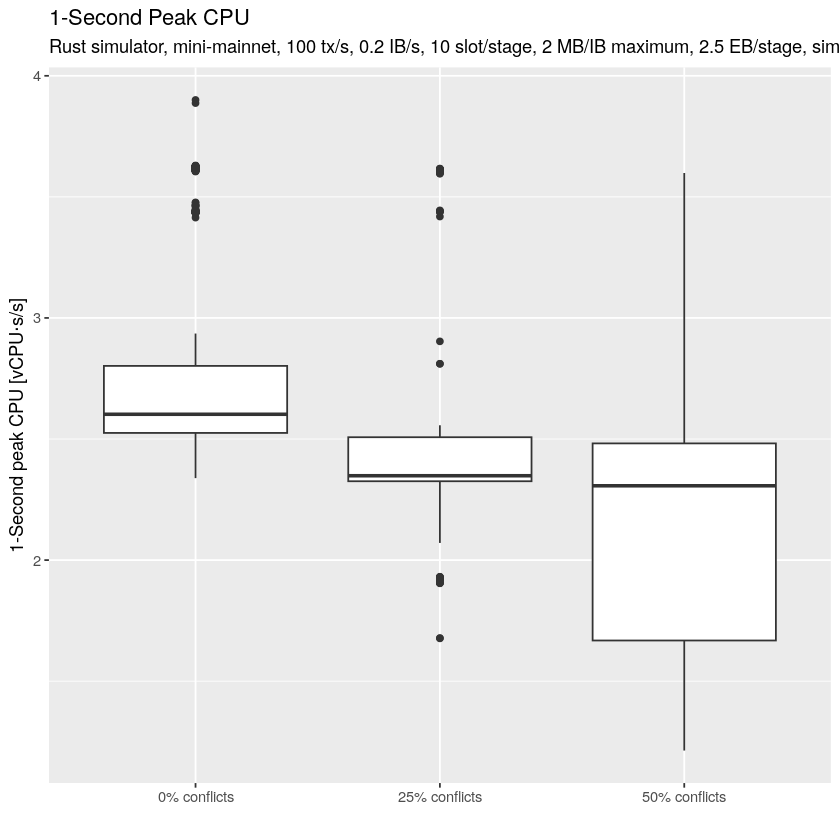

In [45]:
ggplot(
    resources[, .(`Node`, `Conflict fraction`=cxFactor(`Conflict fraction`), `1-Second peak CPU [vCPU⋅s/s]`=`Maximum CPU [s/s]`)], 
    aes(x=`Conflict fraction`, y=`1-Second peak CPU [vCPU⋅s/s]`)
) +
    geom_boxplot() +
#   ylim(0, NA) +
    xlab("") +
    ggtitle("1-Second Peak CPU", label)

In [46]:
ggsave("plots/cxs/cpu-peak.png", units="in", dpi=150, width=9.5, height=5.5)

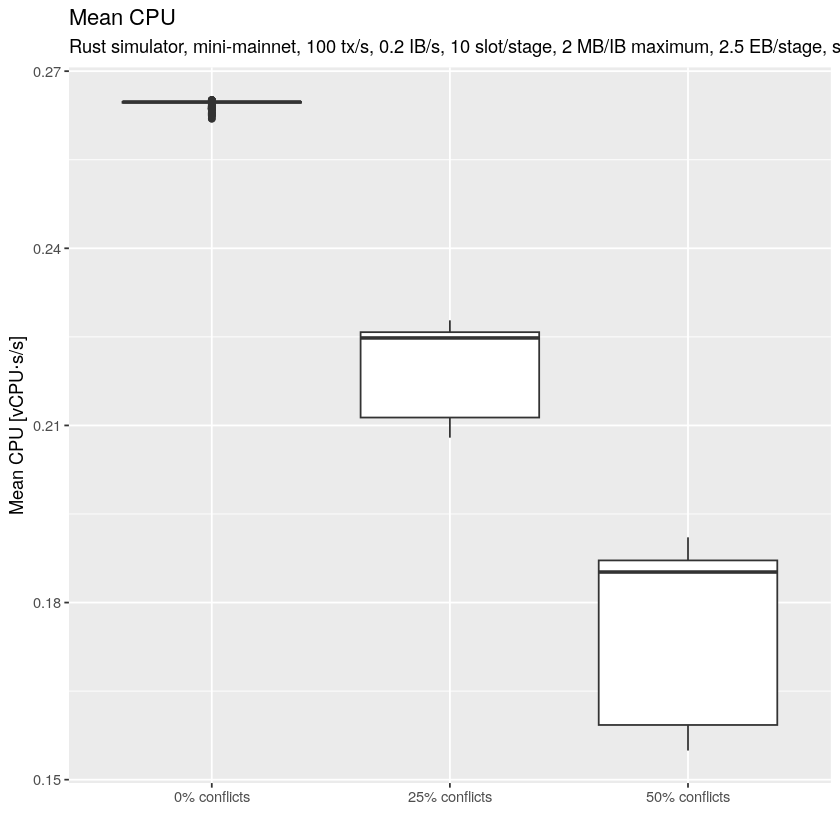

In [47]:
ggplot(
    resources[, .(`Conflict fraction`=cxFactor(`Conflict fraction`), `Node`, `Mean CPU [vCPU⋅s/s]`=`Total CPU [s]`/simFinish
        )
    ], aes(x=`Conflict fraction`, y=`Mean CPU [vCPU⋅s/s]`)
) +
    geom_boxplot() +
#   ylim(0, NA) +
    xlab("") +
    ggtitle("Mean CPU", label)

In [48]:
ggsave("plots/cxs/cpu-mean.png", units="in", dpi=150, width=9.5, height=5.5)

#### Release memory

In [49]:
rm(resources)

### Receipt of messages

#### Read results

In [50]:
receipts <- fread("results/cxs/receipts.csv.gz", stringsAsFactors=TRUE)
receipts[, `Conflict fraction`:=cxFactor(`Conflict fraction`, TRUE)]
receipts %>% summary

 Simulator            Conflict fraction    Kind          
 Rust:154450763   50% conflicts:45441059   EB:   492093  
                  25% conflicts:51794558   IB:   406707  
                  0% conflicts :57215146   RB:   125187  
                                           TX:118072478  
                                           VT: 35354298  
                                                         
                                                         
           Item               Producer         Generated [s]   
 100-node-203:     4494   node-710:   295280   Min.   :  5.13  
 100-node-58 :     4494   node-107:   275190   1st Qu.:218.09  
 100-node-601:     4494   node-282:   269892   Median :379.85  
 110-node-137:     4494   node-493:   268169   Mean   :386.10  
 110-node-15 :     4494   node-227:   267411   3rd Qu.:542.46  
 120-node-416:     4494   node-318:   266974   Max.   :898.13  
 (Other)     :154423799   (Other) :152807847                   
    Size [B]          Re

In [51]:
kinds <- receipts[, unique(`Kind`) %>% sort]
kinds

[1] EB IB RB TX VT
Levels: EB IB RB TX VT

#### Arrival histograms

##### Compare the distributions of elapsed times

In [52]:
arrivalDelayHistogram <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[, .(`Simulator`, `Conflict fraction`, `Elapsed [s]`)],
        aes(x=`Elapsed [s]`)
    ) +
        geom_histogram(binwidth=0.1) +
        facet_grid(`Conflict fraction` ~ `Simulator`, scales=scales) +
#       coord_cartesian(xlim=c(0, 3)) +
        xlab("Time from generation to receipt at node [s]") +
        ylab("Number received") +
        ggtitle(title, subtitle=label) +
        theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

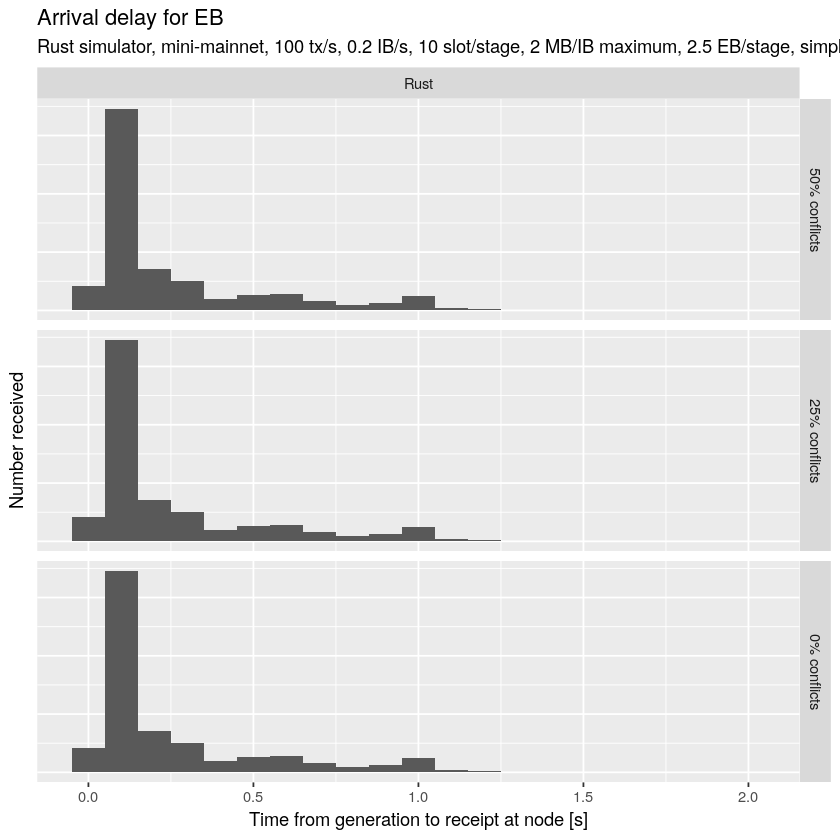

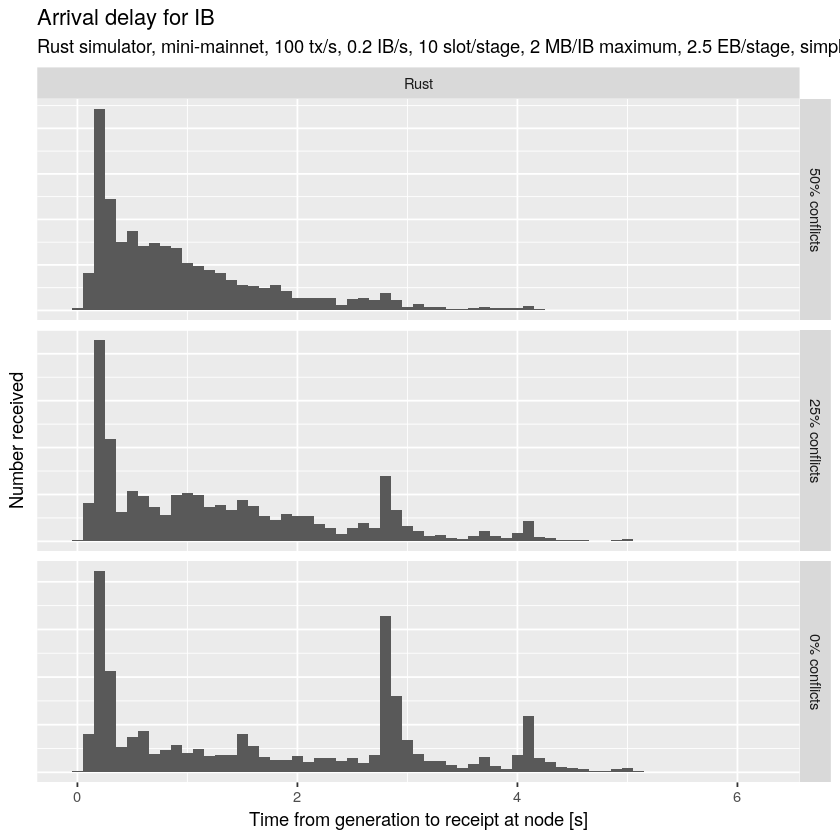

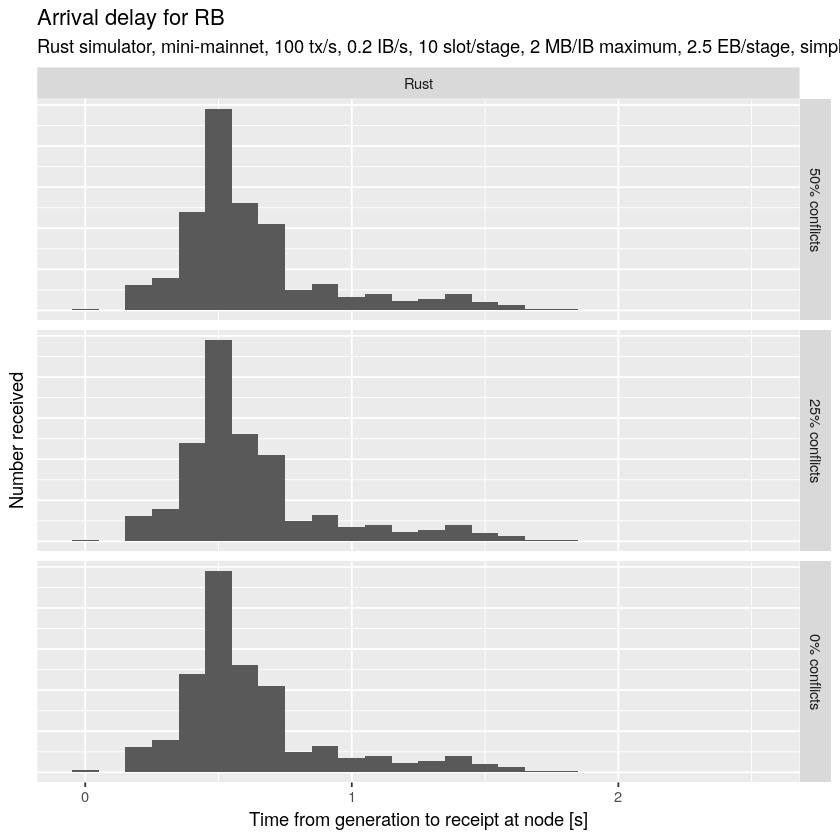

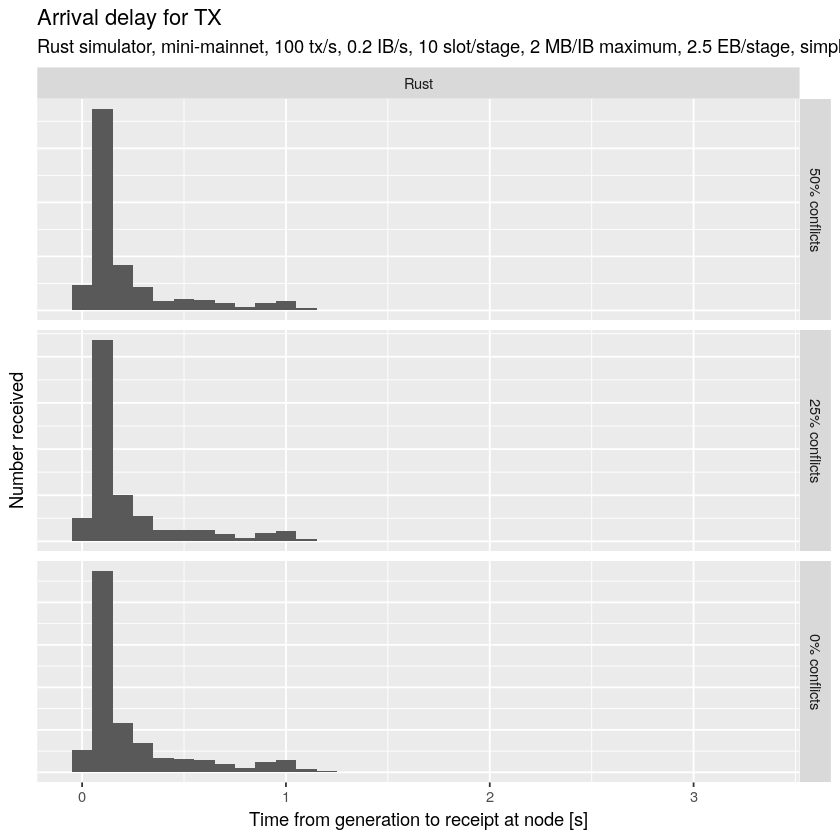

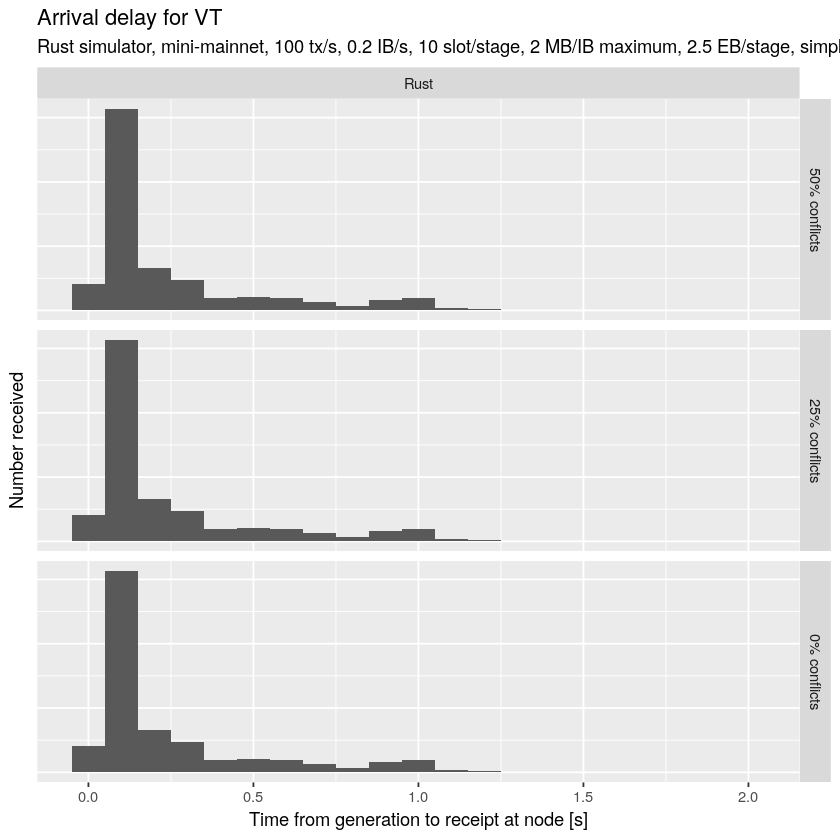

In [53]:
for (k in kinds)
    arrivalDelayHistogram(
        receipts[`Kind` == k],
        paste("Arrival delay for", k),
        scales="free_y",
        outfiles=paste0("plots/cxs/elapsed-", k, ".png")
    ) %>% print

#### Fraction of items arriving

In [54]:
arrivalFractionTimeseries <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[,
            .(`Received`=as.numeric(.N)),
            by=.(`Simulator`, `Conflict fraction`, `Generated [s]`, `Item`)
        ][,
            .(`Total`=as.numeric(.N), `Received`=sum(`Received`)),
            by=.(`Simulator`, `Conflict fraction`, `Generated [s]`)
        ][,
            .(`Received`=sum(`Received`)/sum(`Total`)),
            by=.(`Simulator`, `Conflict fraction`, `Generated [s]`)
        ][, .(`Simulator`, `Conflict fraction`, `Generated [s]`,`Received`)
        ], 
        aes(x=`Generated [s]`, y=`Received`)
    ) +
        geom_point(size=0.5) +
        facet_grid(`Conflict fraction`  ~ `Simulator`, scales=scales) +
        xlab("Time of generation [s]") +
        ylab("Number of nodes receiving") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

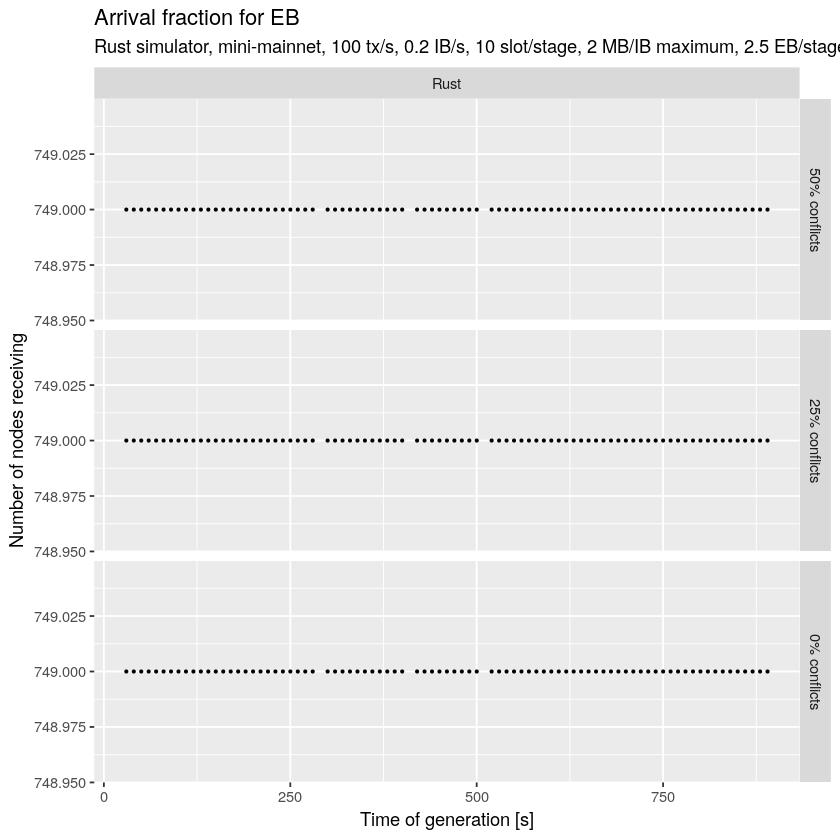

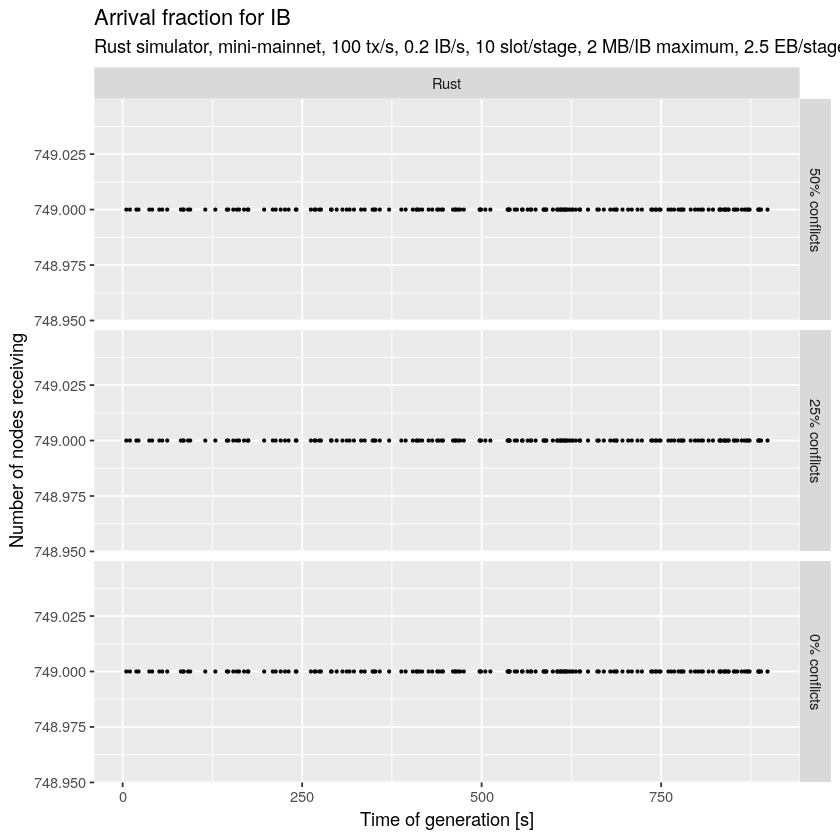

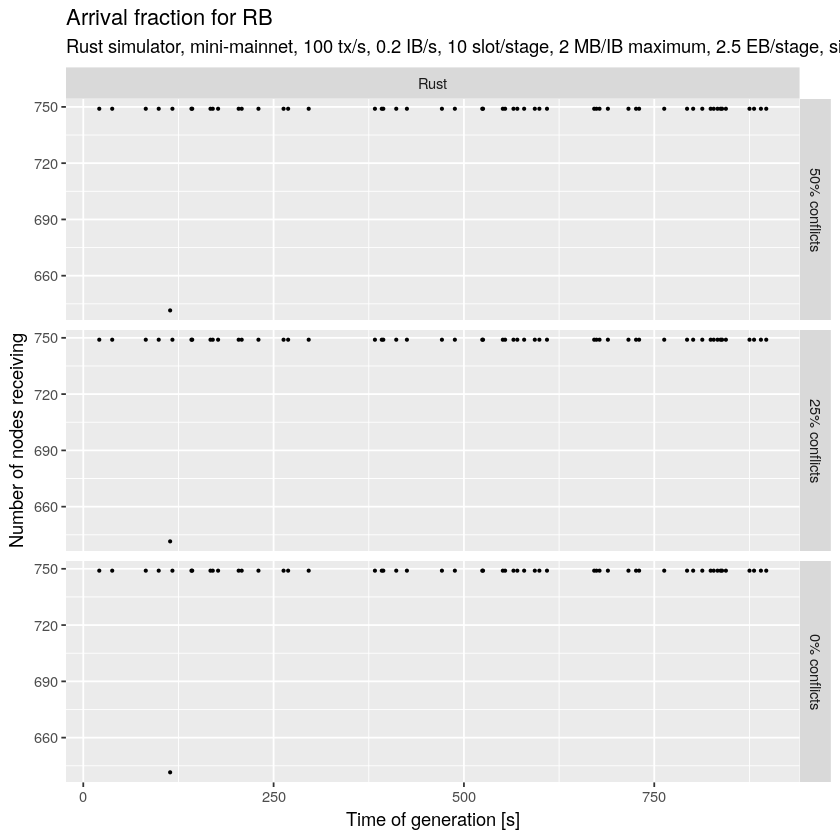

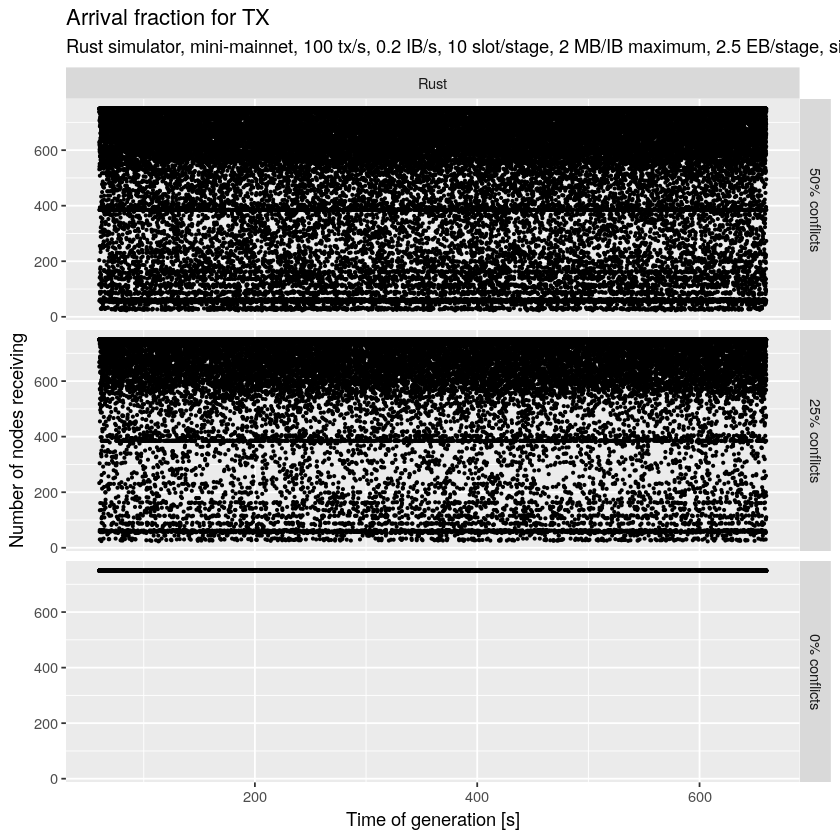

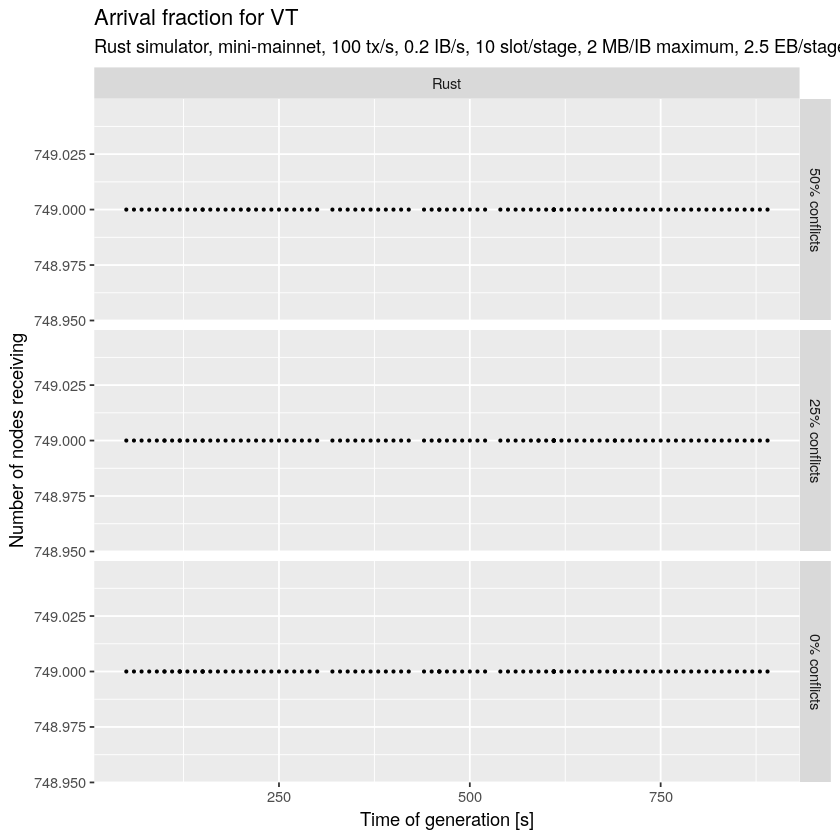

In [55]:
for (k in kinds)
    arrivalFractionTimeseries(
        receipts[`Kind` == k],
        paste("Arrival fraction for", k),
        outfiles=paste0("plots/cxs/arrival-", k, ".png")
    ) %>% print

#### Bandwidth usage

##### Total network bandwidth

In [56]:
totalBandwidthPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[,
            .(
                `Size [Gb]`=8*sum(`Size [B]`, rm.na=TRUE)/1e9
            ),
            by=.(
                `Simulator`,
                `Conflict fraction`,
                `Slot`=floor(`Received [s]`),
                `Message`=`Kind`
            )
        ],
        aes(x=`Slot`, y=`Size [Gb]`, fill=`Message`)
    ) +
        geom_area() +
        facet_grid(`Conflict fraction` ~ `Simulator`, scales=scales) +
#       scale_y_sqrt() +
        xlab("Slot [s]") +
        ylab("Total network ingress [Gb/s]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

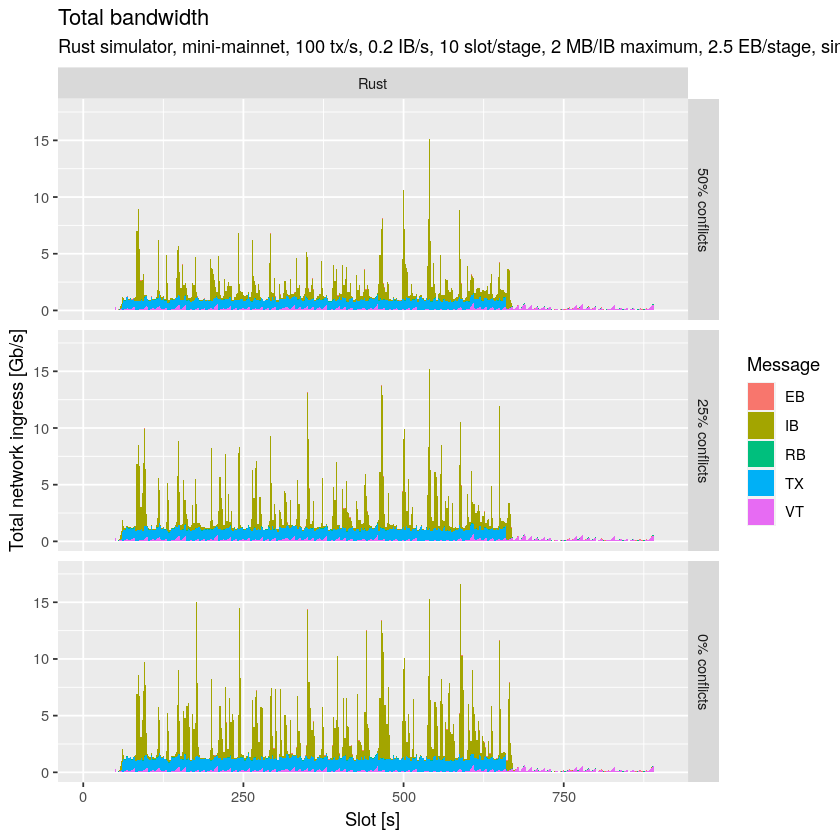

In [57]:
totalBandwidthPlot(
    receipts,
    "Total bandwidth",
    outfiles=paste0("plots/cxs/ingress-total-area.png")
)

##### Bandwidth usage per node

In [58]:
nodeCount <- receipts[, length(unique(`Recipient`))]
nodeCount

[1] 750

In [59]:
meanNodalIngressPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[,
            .(
                `Size [Mb/node]`=8*sum(`Size [B]`)/1e6 /nodeCount
            ),
            by=.(
                `Simulator`,
                `Conflict fraction`,
                `Slot`=floor(`Received [s]`),
                `Message`=`Kind`
            )
        ],
        aes(x=`Slot`, y=`Size [Mb/node]`, fill=`Message`)
    ) +
        geom_area() +
        facet_grid(`Conflict fraction` ~ `Simulator`, scales=scales) +
#       scale_y_sqrt() +
        xlab("Slot [s]") +
        ylab("Mean network ingress among nodes [Mb/s]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

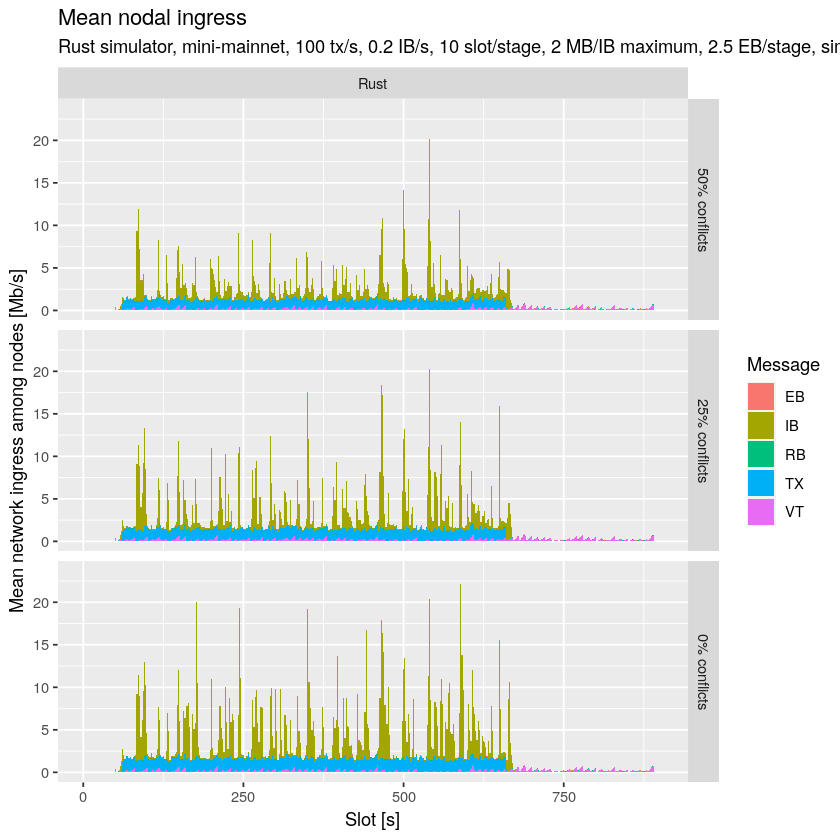

In [60]:
meanNodalIngressPlot(
    receipts, 
    "Mean nodal ingress",
    outfiles=paste0("plots/cxs/ingress-average-area.png")
)

In [61]:
peakNodalIngressPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[,
            .(
                `Size [Mb]`=8*sum(`Size [B]`, rm.na=TRUE)/1e6
            ),
            by=.(
                `Simulator`,
                `Conflict fraction`,
                `Slot`=floor(`Received [s]`),
                `Message`=`Kind`,
                `Recipient`
            )
        ][,
            .(`Size [Mb]`=max(`Size [Mb]`)),
            by=.(`Simulator`, `Conflict fraction`, `Slot`, `Message`)
        ],
        aes(x=`Slot`, y=`Size [Mb]`, color=`Message`)
    ) +
        geom_point(size=0.5) +
        facet_grid(`Conflict fraction` ~ `Simulator`, scales=scales) +
#       scale_y_sqrt() +
        xlab("Slot [s]") +
        ylab("Maximum network ingress among nodes [Mb/s]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

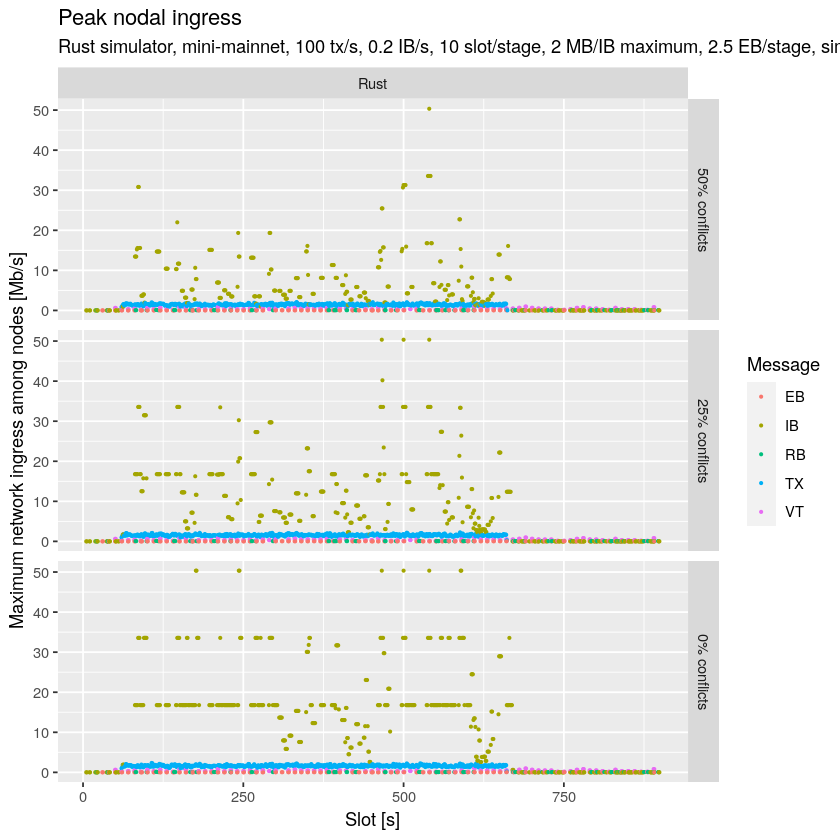

In [62]:
peakNodalIngressPlot(
    receipts, 
    "Peak nodal ingress",
    outfiles=paste0("plots/cxs/ingress-peak-point.png")
)

#### Release memory

In [63]:
rm(receipts)

### CPU usage

#### Read results

In [64]:
cpus <- fread("results/cxs/cpus.csv.gz", stringsAsFactors=TRUE)
cpus %>% summary

 Simulator        Conflict fraction      Slot             Node          
 Rust:211635385   Min.   :0.0000    Min.   :  5.0   node-469:   293969  
                  1st Qu.:0.0000    1st Qu.:224.0   node-745:   293707  
                  Median :0.2500    Median :394.0   node-741:   293214  
                  Mean   :0.2361    Mean   :409.8   node-743:   293157  
                  3rd Qu.:0.5000    3rd Qu.:590.0   node-483:   293119  
                  Max.   :0.5000    Max.   :900.0   node-742:   293021  
                                                    (Other) :209875198  
      Task            Duration [s]     
 ValTX  :118072478   Min.   :0.000164  
 ValVote: 92007909   1st Qu.:0.000816  
 ValEB  :   492093   Median :0.001500  
 ValIB  :   406707   Mean   :0.002116  
 ValIH  :   406707   3rd Qu.:0.001500  
 ValRB  :   125187   Max.   :1.098576  
 (Other):   124304                     

In [65]:
cpusNode <-
cpus[
    ,
    .(`Duration [s]`=sum(`Duration [s]`)),
    by=.(`Simulator`, `Conflict fraction`, `Node`, `Slot`)
]

#### Peak CPU usage

##### Histogram

In [66]:
peakCpuHistogram <- function(cs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        cs[,
            .(`Duration [%]`=100*max(`Duration [s]`)),
            by=.(`Simulator`, `Conflict fraction`, `Slot`)
        ], 
        aes(x=`Duration [%]`)
    ) +
        geom_histogram(binwidth=10) +
        facet_grid(`Conflict fraction` ~ `Simulator`, scales=scales) +
      # coord_cartesian(xlim=c(0, 700)) +
        xlab("Peak CPU load [%]") +
        ylab("Number of slots") +
        ggtitle(title, subtitle="label")
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

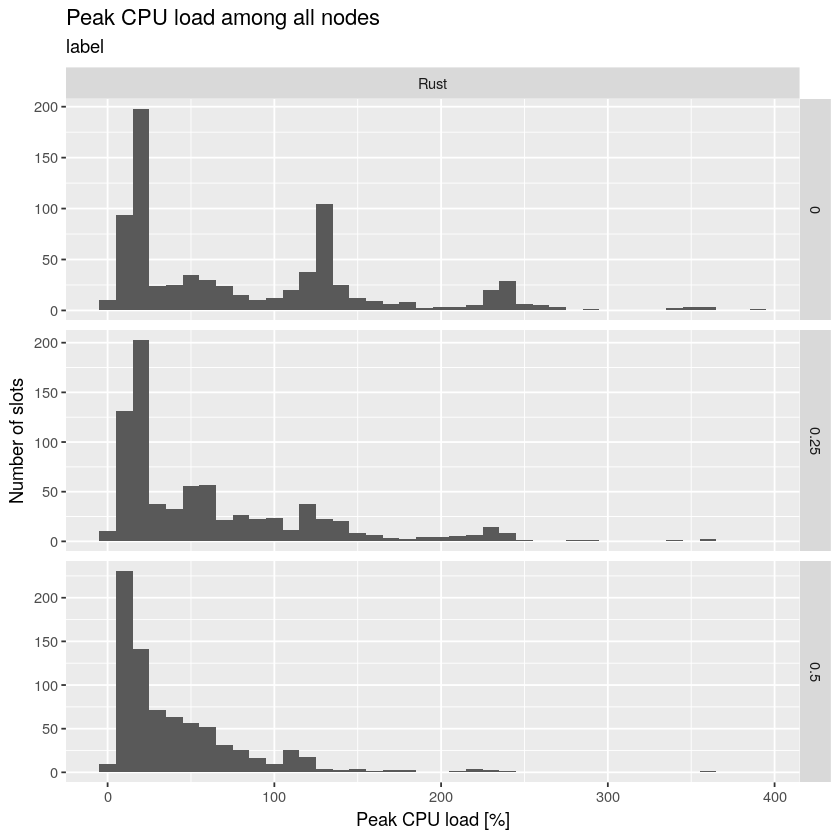

In [67]:
peakCpuHistogram(
    cpusNode, 
    "Peak CPU load among all nodes",
    scales="free_y",
    outfiles=paste0("plots/cxs/cpu-peak-histogram.png")
)

##### Time series

In [68]:
peakCpuTimeseries <- function(cs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        cs[,
            .(`Duration [%]`=100*mean(`Duration [s]`)),
            by=.(`Simulator`, `Conflict fraction`, `Slot`)
        ], 
        aes(x=`Slot`, y=`Duration [%]`)) +
        geom_line() +
        facet_grid(`Conflict fraction` ~ `Simulator`, scale=scales) +
        scale_y_sqrt() +
        xlab("Slot") +
        ylab("Mean CPU load [%]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

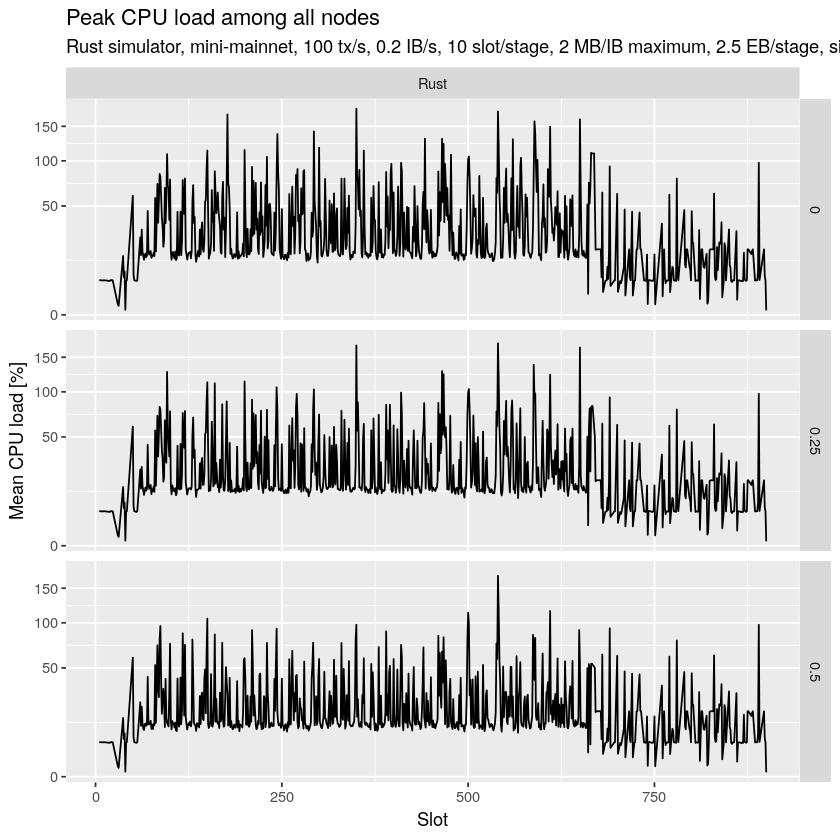

In [69]:
peakCpuTimeseries(
    cpusNode,
    "Peak CPU load among all nodes",
    outfiles=paste0("plots/cxs/cpu-peak-timeseries.png")
)

#### Mean CPU usage

##### Histogram

In [70]:
meanCpuHistogram <- function(cs, nodeSeconds, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        cs[,
            .(`Duration [%]`=100*sum(`Duration [s]`)/nodeSeconds),
            by=.(`Simulator`, `Conflict fraction`, `Task`)
        ], 
        aes(x="", fill=`Task`, y=`Duration [%]`)) +
        geom_bar(stat = "identity") +
        facet_grid(`Conflict fraction` ~ `Simulator`, scales=scales) +
        xlab("") +
        ylab("Mean CPU load [%]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

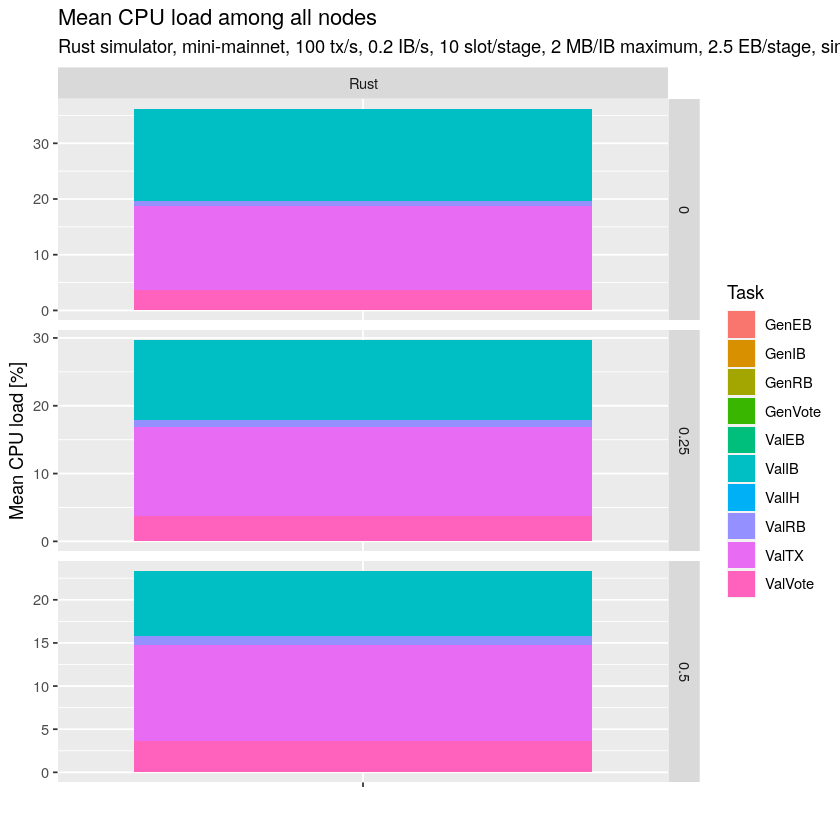

In [71]:
meanCpuHistogram(
    cpus[`Slot` >= txFirst & `Slot` < txLast],
    nodeCount * txWindow, 
    "Mean CPU load among all nodes", 
    scales="free_y",
    outfiles=paste0("plots/cxs/cpu-mean-histogram.png")
)

##### Time series

In [72]:
meanCpuTimeseries <- function(cs, nodeSeconds, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        cs[,
            .(`Duration [%]`=100*sum(`Duration [s]`)/nodeSeconds),
            by=.(`Simulator`, `Conflict fraction`, `Slot`, `Task`)
        ], 
        aes(x=`Slot`, y=`Duration [%]`, color=`Task`)
    ) +
        geom_point(size=0.25, alpha=0.75) +
        facet_grid(`Conflict fraction` ~ `Simulator`, scales=scales) +
        scale_y_sqrt() +
        xlab("Slot") +
        ylab("Mean CPU load [%]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

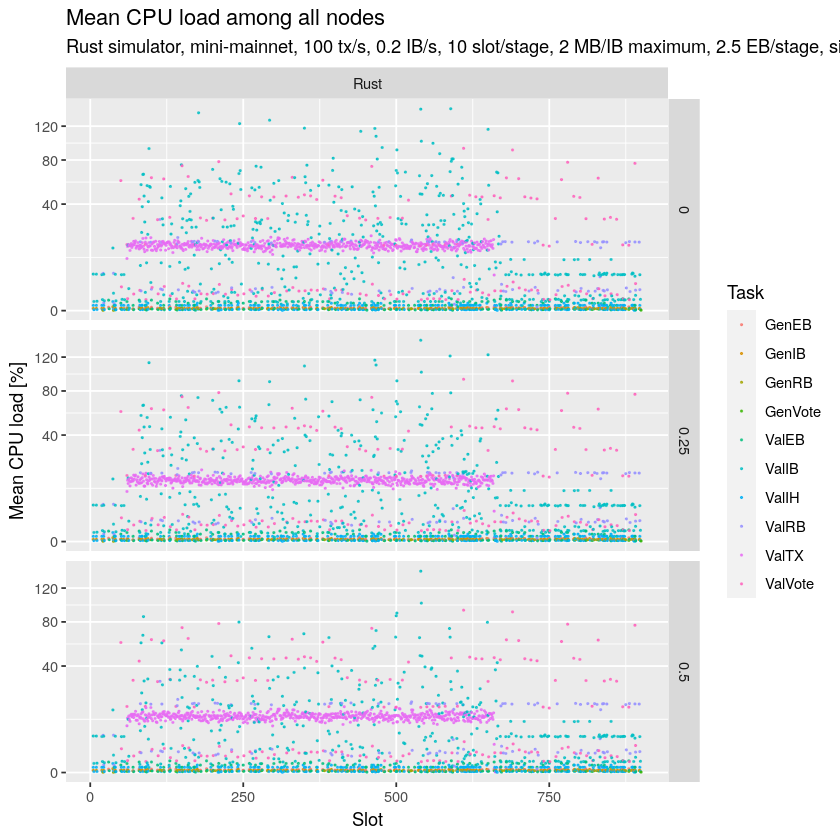

In [73]:
meanCpuTimeseries(
    cpus, 
    nodeCount, 
    "Mean CPU load among all nodes",
    outfiles=paste0("plots/cxs/cpu-mean-timeseries.png")
)

#### Release memory

In [74]:
rm(cpus, cpusNode)